### 04 – Multi-Class Classification (Attack Type Identification)

This notebook implements Part B of the project:
multi-class classification of time windows into specific attack types.

Each sample represents aggregated user behavior within a
30-minute time window.

Classes include:
- Normal
- Cryptojacking
- Billing attack
- Lateral movement
- Vulnerability scanning
- Targeted vulnerabilities in services

We compare:
- Logistic Regression
- Random Forest

Evaluation focuses on:
- Weighted F1-score
- Confusion matrix
- Per-class recall

Weighted metrics are used due to severe class imbalance.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load window-level features
df = pd.read_parquet("../data/processed/window_features_30.parquet")

print("Window-level dataset shape:", df.shape)
df.head()


Window-level dataset shape: (15789, 12)


,userIdentity.userName,time_window,num_events,num_unique_events,num_services,num_regions,num_source_ips,num_read_only,num_management_events,num_errors,label_binary,label_multiclass
0,HIDDEN_DUE_TO_SECURITY_REASONS,2017-05-17 23:00:00+00:00,4,2,1,1,1,0,0,0,1,Login
1,HIDDEN_DUE_TO_SECURITY_REASONS,2018-02-26 01:00:00+00:00,2,2,1,1,1,0,0,0,1,Login
2,HIDDEN_DUE_TO_SECURITY_REASONS,2018-02-26 18:30:00+00:00,7,2,1,1,1,0,0,0,1,Login
3,HIDDEN_DUE_TO_SECURITY_REASONS,2018-02-26 19:00:00+00:00,2,2,1,1,1,0,0,0,1,Login
4,HIDDEN_DUE_TO_SECURITY_REASONS,2018-03-17 17:30:00+00:00,2,2,1,1,1,0,0,0,1,Login


In [3]:
# Multiclass target
y = df["label_multiclass"]

# Feature matrix (drop identifiers and labels)
X = df.drop(columns=[
    "userIdentity.userName",
    "time_window",
    "label_binary",
    "label_multiclass"
])


In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Classes:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"{i}: {cls}")


Classes:
0: AssociateResources
1: CreateObject
2: Delete
3: EnableObjects
4: GetInfo
5: ListResources
6: Login
7: ModifyExistingResource
8: Normal


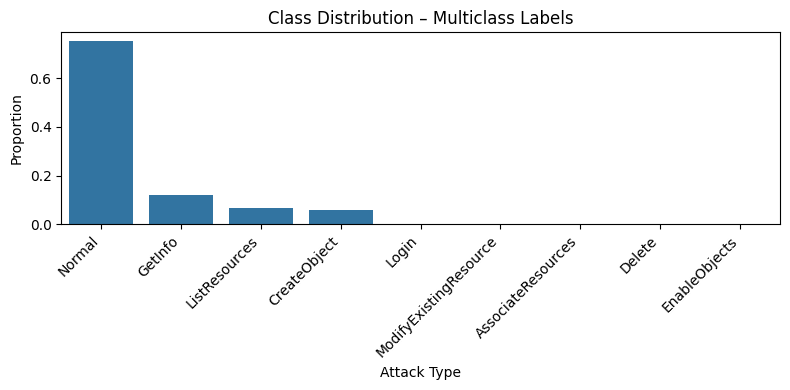

In [5]:
class_distribution = pd.Series(y).value_counts(normalize=True)

plt.figure(figsize=(8, 4))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.xticks(rotation=45, ha="right")
plt.title("Class Distribution – Multiclass Labels")
plt.ylabel("Proportion")
plt.xlabel("Attack Type")
plt.tight_layout()
plt.show()


In [6]:
# Count samples per class
class_counts = pd.Series(y_encoded).value_counts()
class_counts


8    11847
4     1885
5     1079
1      957
6        7
7        6
0        5
2        2
3        1
Name: count, dtype: int64

In [7]:
# Keep only classes with at least 2 samples  -- אי אפשר לפצל אותם לאימון ומבחן
valid_classes = class_counts[class_counts >= 2].index

mask = np.isin(y_encoded, valid_classes)

X_filtered = X.loc[mask]
y_filtered = y_encoded[mask]


#חשוב למצגת !!

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered,
    y_filtered,
    test_size=0.2,
    stratify=y_filtered,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (12630, 8)
Test size: (3158, 8)


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


In [10]:
LogisticRegression(
    #solver="lbfgs",
    class_weight="balanced",
    max_iter=2000,
    random_state=42
)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [11]:
logreg_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10]
}


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logreg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        #solver="lbfgs",
        class_weight="balanced",
        max_iter=2000,
        random_state=42
    ))
])


In [13]:
logreg_grid = GridSearchCV(
    logreg_pipeline,
    logreg_param_grid,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1
)

logreg_grid.fit(X_train, y_train)

print("Best Logistic Regression params:", logreg_grid.best_params_)
print("Best CV weighted F1:", logreg_grid.best_score_)



/Users/sapirshenhav/Desktop/hit msc/ML/GNN-AnomalyDetection-Final/venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Logistic Regression params: {'clf__C': 1}
Best CV weighted F1: 0.8701000779600218


In [14]:
from sklearn.ensemble import RandomForestClassifier


In [15]:
rf_pipeline = Pipeline(steps=[
    ("clf", RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])


In [16]:
rf_param_grid = {
    'clf__n_estimators': [100, 500],         # מספר העצים ביער
    'clf__max_depth': [10, 8],        # עומק העץ (מונע Overfitting)
    'clf__min_samples_split': [10,20],    # מינימום דוגמאות לפיצול צומת
    'clf__max_features': ['sqrt', 'log2'],   # מספר הפיצ'רים הנבדקים בכל פיצול (mtry)
    #'clf__bootstrap': [True]   #זה כבר אוטומטית
}


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_pipeline = Pipeline(steps=[
    ("clf", RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])


In [18]:
from sklearn.model_selection import GridSearchCV

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("Best Random Forest params:", rf_grid.best_params_)
print("Best CV weighted F1:", rf_grid.best_score_)


#Best Random Forest params: {'clf__max_depth': 20, 'clf__min_samples_split': 10, 'clf__n_estimators': 500}
#Best CV weighted F1: 0.8980112442950515

/Users/sapirshenhav/Desktop/hit msc/ML/GNN-AnomalyDetection-Final/venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/sapirshenhav/Desktop/hit msc/ML/GNN-AnomalyDetection-Final/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Random Forest params: {'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__min_samples_split': 20, 'clf__n_estimators': 500}
Best CV weighted F1: 0.8968901283884844


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

logreg_best = logreg_grid.best_estimator_
rf_best = rf_grid.best_estimator_


In [20]:
import numpy as np

labels_present = np.unique(y_test)
labels_present


array([0, 1, 4, 5, 6, 7, 8])

In [21]:
y_pred_logreg = logreg_best.predict(X_test)

print(classification_report(
    y_test,
    y_pred_logreg,
    labels=labels_present,
    target_names=label_encoder.inverse_transform(labels_present)
))


                        precision    recall  f1-score   support

    AssociateResources       0.00      0.00      0.00         1
          CreateObject       0.84      0.92      0.88       192
               GetInfo       0.85      0.64      0.73       377
         ListResources       0.30      0.10      0.15       216
                 Login       0.02      1.00      0.04         1
ModifyExistingResource       0.06      1.00      0.11         1
                Normal       0.94      1.00      0.97      2370

             micro avg       0.89      0.89      0.89      3158
             macro avg       0.43      0.66      0.41      3158
          weighted avg       0.88      0.89      0.88      3158



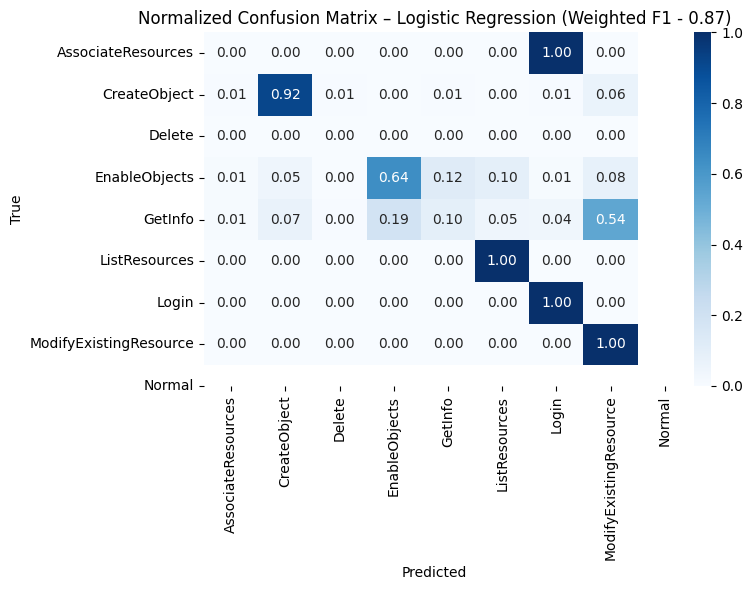

In [22]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg, normalize="true")

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_logreg,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("Normalized Confusion Matrix – Logistic Regression (Weighted F1 - 0.87)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [23]:
import numpy as np

labels_present = np.unique(y_test)
labels_present


array([0, 1, 4, 5, 6, 7, 8])

In [24]:
y_pred_rf = rf_best.predict(X_test)

print(classification_report(
    y_test,
    y_pred_rf,
    labels=labels_present,
    target_names=label_encoder.inverse_transform(labels_present)
))


                        precision    recall  f1-score   support

    AssociateResources       0.00      0.00      0.00         1
          CreateObject       0.99      0.90      0.95       192
               GetInfo       0.90      0.84      0.87       377
         ListResources       0.46      0.39      0.42       216
                 Login       0.10      1.00      0.18         1
ModifyExistingResource       0.07      1.00      0.12         1
                Normal       0.95      0.97      0.96      2370

             micro avg       0.91      0.91      0.91      3158
             macro avg       0.50      0.73      0.50      3158
          weighted avg       0.91      0.91      0.91      3158



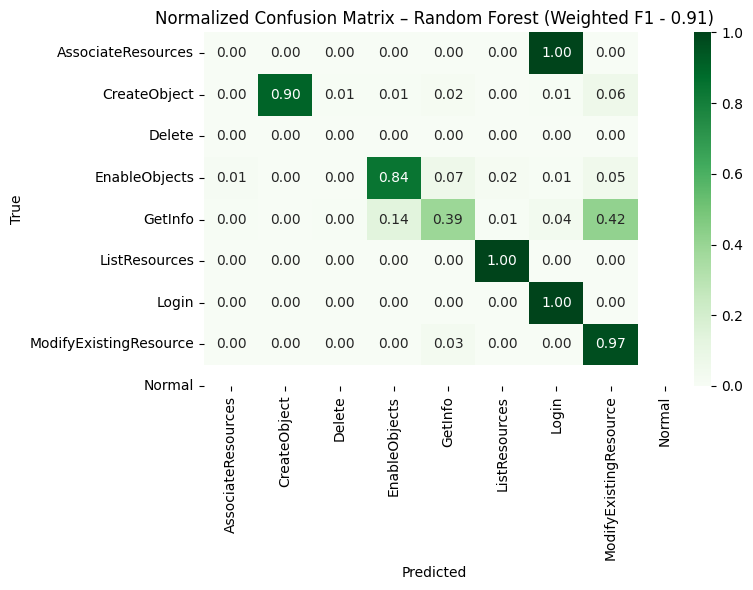

In [25]:
cm_rf = confusion_matrix(y_test, y_pred_rf, normalize="true")

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("Normalized Confusion Matrix – Random Forest (Weighted F1 - 0.91)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [26]:
import numpy as np

labels_present = np.unique(y_test)


In [27]:
report = classification_report(
    y_test,
    y_pred_rf,
    labels=labels_present,
    target_names=label_encoder.inverse_transform(labels_present),
    output_dict=True
)



In [28]:
recall_per_class = {
    cls: report[cls]["recall"]
    for cls in report
    if cls not in ["accuracy", "macro avg", "weighted avg"]
}


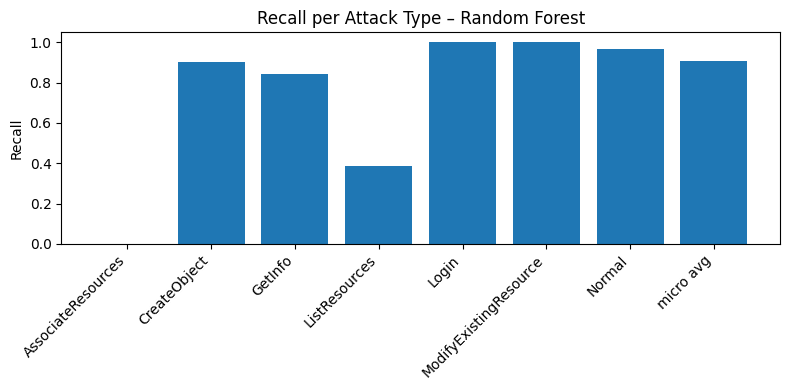

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(recall_per_class.keys(), recall_per_class.values())
plt.xticks(rotation=45, ha="right")
plt.ylabel("Recall")
plt.title("Recall per Attack Type – Random Forest")
plt.tight_layout()
plt.show()
